# RNN Sentiment Analysis (PyTorch)
Rotten Tomatoes • Model selection + Uni vs Bi + Embedding stability (vs GloVe)

This notebook implements a strong RNN-based baseline using **(Bi)GRU/LSTM + Attention pooling**.


In [ ]:

# import necessary libraries
from datasets import load_dataset
import re, math, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Repro
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

rt = load_dataset("rotten_tomatoes")

# TextVectorization-lignende standardisering: lower + strip punctuation
# (Matcher ideen "lower_and_strip_punctuation" + whitespace split)
_punct_re = re.compile(r"[^\w\s']")  
_space_re = re.compile(r"\s+")

def standardize_tf_like(s: str) -> str:
    s = s.lower()
    s = _punct_re.sub(" ", s)
    s = _space_re.sub(" ", s).strip()
    return s

def tokenize_tf_like(s: str):
    return standardize_tf_like(s).split()

from collections import Counter

def build_vocab_tf_like(texts, max_tokens=20000, min_freq=1):
    """
    TF-lignende:
    - special tokens: pad=0, oov=1
    - sortér efter frekvens desc, og alfabetisk ved ties (stabilt)
    """
    c = Counter()
    for t in texts:
        c.update(tokenize_tf_like(t))
    items = [(w, f) for w, f in c.items() if f >= min_freq]
    items.sort(key=lambda x: (-x[1], x[0]))  # freq desc, alpha asc

    stoi = {"<pad>": 0, "<unk>": 1}
    itos = ["<pad>", "<unk>"]
    for w, _ in items:
        if w in stoi:
            continue
        if len(itos) >= max_tokens:
            break
        stoi[w] = len(itos)
        itos.append(w)
    return stoi, itos

def encode(text, stoi, seq_len=60):
    toks = tokenize_tf_like(text)
    ids = [stoi.get(tok, 1) for tok in toks]  # 1 = <unk>
    if len(ids) < seq_len:
        ids = ids + [0] * (seq_len - len(ids))
    else:
        ids = ids[:seq_len]
    return np.asarray(ids, dtype=np.int64)

class RTDataset(Dataset):
    def __init__(self, split, stoi, seq_len=60):
        self.texts = split["text"]
        self.labels = split["label"]
        self.stoi = stoi
        self.seq_len = seq_len
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = encode(self.texts[idx], self.stoi, self.seq_len)
        y = float(self.labels[idx])
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.float32)

def make_loaders(vocab_size=20000, seq_len=60, batch_size=64):
    stoi, itos = build_vocab_tf_like(rt["train"]["text"], max_tokens=vocab_size)
    train_ds = RTDataset(rt["train"], stoi, seq_len)
    val_ds   = RTDataset(rt["validation"], stoi, seq_len)
    test_ds  = RTDataset(rt["test"], stoi, seq_len)

    g = torch.Generator()
    g.manual_seed(SEED)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=g, num_workers=0)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader, test_loader, stoi, itos

train_loader, val_loader, test_loader, stoi, itos = make_loaders()
print("Vocab:", len(itos))


c:\Users\oliv9\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu
Vocab: 17433


In [ ]:

# GRU and Attention Pooling

class AttentionPool(nn.Module):
    """
    Additiv attention over tidssteps.
    Input: H (B, T, D)
    Output: pooled (B, D)
    """
    def __init__(self, dim):
        super().__init__()
        self.proj = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, 1, bias=False)

    def forward(self, H, mask=None):
        scores = self.v(torch.tanh(self.proj(H))).squeeze(-1)  # (B, T)
        if mask is not None:
            scores = scores.masked_fill(~mask, -1e9)
        w = torch.softmax(scores, dim=1)  # (B, T)
        pooled = (H * w.unsqueeze(-1)).sum(dim=1)  # (B, D)
        return pooled, w

class RNNClassifier(nn.Module):
    def __init__(
        self,
        rnn_type="gru",
        vocab_size=20000,
        embed_dim=200,
        hidden_size=256,
        num_layers=1,
        dropout=0.35,
        bidirectional=True,
        pad_idx=0
    ):
        super().__init__()
        self.rnn_type = rnn_type.lower()
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        rnn_cls = nn.GRU if self.rnn_type == "gru" else nn.LSTM
        self.rnn = rnn_cls(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.0 if num_layers == 1 else dropout
        )

        out_dim = hidden_size * (2 if bidirectional else 1)
        self.attn = AttentionPool(out_dim)

        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(out_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        emb = self.embedding(x)          # (B, T, E)
        H, _ = self.rnn(emb)             # (B, T, D)
        mask = (x != 0)                  # pad-mask
        pooled, attn_w = self.attn(H, mask=mask)
        logits = self.mlp(pooled).squeeze(1)  # (B,)
        return logits, attn_w

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


In [ ]:

# Train/eval + early stopping

def acc_from_logits(logits, y):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    losses, accs = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits, _ = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        accs.append(acc_from_logits(logits, y))
    return float(np.mean(losses)), float(np.mean(accs))

def train_one_epoch(model, loader, optimizer, criterion, grad_clip=1.0, use_amp=True):
    model.train()
    losses, accs = [], []
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(use_amp and device.type == "cuda")):
            logits, _ = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        if grad_clip is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        accs.append(acc_from_logits(logits, y))

    return float(np.mean(losses)), float(np.mean(accs))

def fit(config, epochs=12, batch_size=64, patience=2, verbose=False):
    train_loader, val_loader, test_loader, stoi, itos = make_loaders(
        vocab_size=config["vocab_size"],
        seq_len=config["seq_len"],
        batch_size=batch_size
    )

    model = RNNClassifier(
        rnn_type=config["rnn_type"],
        vocab_size=config["vocab_size"],
        embed_dim=config["embed_dim"],
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        dropout=config["dropout"],
        bidirectional=config["bidirectional"]
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )

    hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_val_loss = float("inf")
    best_state = None
    bad = 0

    for ep in range(1, epochs+1):
        tr_l, tr_a = train_one_epoch(model, train_loader, optimizer, criterion,
                                     grad_clip=config["grad_clip"], use_amp=True)
        va_l, va_a = evaluate(model, val_loader, criterion)

        hist["train_loss"].append(tr_l); hist["train_acc"].append(tr_a)
        hist["val_loss"].append(va_l);   hist["val_acc"].append(va_a)

        if va_l < best_val_loss - 1e-5:
            best_val_loss = va_l
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

        if verbose:
            print(f"ep {ep:02d} | tr loss {tr_l:.4f} acc {tr_a:.3f} | va loss {va_l:.4f} acc {va_a:.3f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, hist, (train_loader, val_loader, test_loader, stoi, itos)


## Hyperparameter search + visualisering
Vi laver et kontrolleret sweep over hidden size, dropout og learning rate på en UNI-model.


In [ ]:

# Hyperparameter search and visualisering

base = dict(
    rnn_type="gru",
    vocab_size=20000,
    seq_len=60,
    embed_dim=200,
    hidden_size=256,
    num_layers=1,
    dropout=0.35,
    bidirectional=False,   # UNI for fair comparison later
    lr=2e-3,
    weight_decay=1e-2,
    grad_clip=1.0,
)

grid = []
for hidden in [128, 256]:
    for dropout in [0.25, 0.35]:
        for lr in [1e-3, 2e-3]:
            cfg = dict(base)
            cfg["hidden_size"] = hidden
            cfg["dropout"] = dropout
            cfg["lr"] = lr
            grid.append(cfg)

results = []
histories = []

for i, cfg in enumerate(grid):
    model, hist, pack = fit(cfg, epochs=12, batch_size=64, patience=2, verbose=False)
    best_val_acc = max(hist["val_acc"])
    best_val_loss = min(hist["val_loss"])
    results.append({
        "run": i,
        "hidden": cfg["hidden_size"],
        "dropout": cfg["dropout"],
        "lr": cfg["lr"],
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "params": count_params(model)
    })
    histories.append(hist)

df = pd.DataFrame(results).sort_values(["best_val_acc","best_val_loss"], ascending=[False, True]).reset_index(drop=True)
df.head(10)


C:\Users\oliv9\AppData\Local\Temp\ipykernel_22068\2813768731.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))
C:\Users\oliv9\AppData\Local\Temp\ipykernel_22068\2813768731.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.type == "cuda")):


,run,hidden,dropout,lr,best_val_acc,best_val_loss,params
0,3,128,0.35,0.002,0.749737,0.566662,4160001
1,1,128,0.25,0.002,0.741028,0.557210,4160001
2,7,256,0.35,0.002,0.737351,0.550887,4450817
3,2,128,0.35,0.001,0.730523,0.568629,4160001
4,4,256,0.25,0.001,0.714329,0.587459,4450817
5,5,256,0.25,0.002,0.702293,0.663620,4450817
6,6,256,0.35,0.001,0.698617,0.587239,4450817
7,0,128,0.25,0.001,0.682948,0.596100,4160001


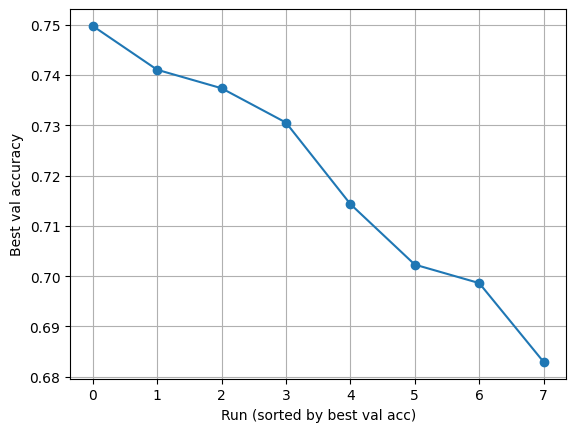

dropout      0.25      0.35
hidden                     
128      0.711988  0.740130
256      0.708311  0.717984


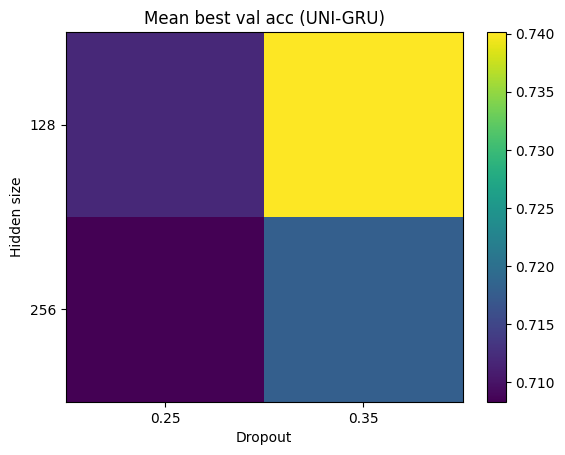

In [9]:
# Visualiser hyperparameter-effekt: Val accuracy pr run
plt.figure()
plt.plot(df["best_val_acc"].values, marker="o")
plt.xlabel("Run (sorted by best val acc)")
plt.ylabel("Best val accuracy")
plt.grid(True)
plt.show()

# Heatmap-ish: groupby hidden/dropout og se gennemsnit val acc
pivot = df.pivot_table(index="hidden", columns="dropout", values="best_val_acc", aggfunc="mean")
print(pivot)

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(pivot.shape[1]), pivot.columns)
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.xlabel("Dropout")
plt.ylabel("Hidden size")
plt.title("Mean best val acc (UNI-GRU)")
plt.colorbar()
plt.show()


## Train best UNI + test + learning curves

C:\Users\oliv9\AppData\Local\Temp\ipykernel_22068\2813768731.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))
C:\Users\oliv9\AppData\Local\Temp\ipykernel_22068\2813768731.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.type == "cuda")):


ep 01 | tr loss 0.6369 acc 0.636 | va loss 0.5920 acc 0.697
ep 02 | tr loss 0.4525 acc 0.788 | va loss 0.5689 acc 0.719
ep 03 | tr loss 0.2615 acc 0.893 | va loss 0.6713 acc 0.719
UNI Test acc: 0.7204569332739886
UNI Params: 4160001


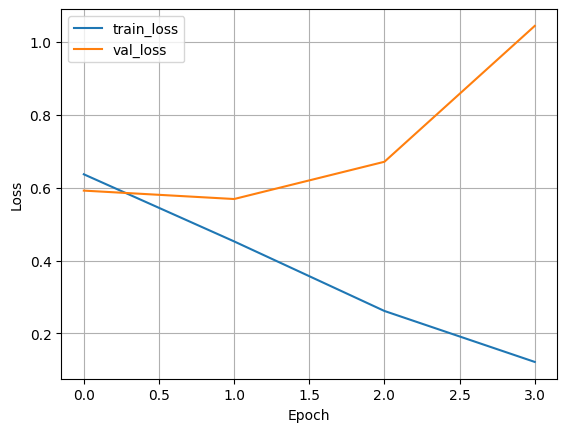

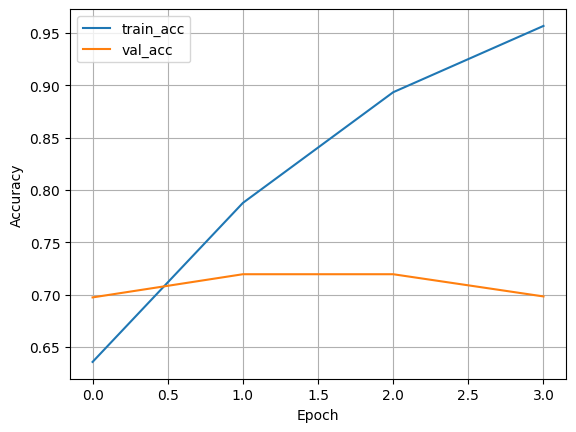

In [ ]:

# Træn endelig "bedste UNI" and test

best_uni = df.iloc[0].to_dict()

best_cfg_uni = None
for cfg in grid:
    if cfg["hidden_size"] == best_uni["hidden"] and cfg["dropout"] == best_uni["dropout"] and cfg["lr"] == best_uni["lr"]:
        best_cfg_uni = cfg
        break

uni_model, uni_hist, uni_pack = fit(best_cfg_uni, epochs=12, batch_size=64, patience=2, verbose=True)
train_loader, val_loader, test_loader, uni_stoi, uni_itos = uni_pack

criterion = nn.BCEWithLogitsLoss()
test_loss, test_acc = evaluate(uni_model, test_loader, criterion)
print("UNI Test acc:", test_acc)
print("UNI Params:", count_params(uni_model))

plt.figure()
plt.plot(uni_hist["train_loss"], label="train_loss")
plt.plot(uni_hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(uni_hist["train_acc"], label="train_acc")
plt.plot(uni_hist["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()


## Uni vs Bi comparison (value of bidirectionality)

C:\Users\oliv9\AppData\Local\Temp\ipykernel_22068\2813768731.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))
C:\Users\oliv9\AppData\Local\Temp\ipykernel_22068\2813768731.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.type == "cuda")):


ep 01 | tr loss 0.6252 acc 0.646 | va loss 0.5989 acc 0.660
ep 02 | tr loss 0.4272 acc 0.808 | va loss 0.5739 acc 0.716
ep 03 | tr loss 0.2323 acc 0.905 | va loss 0.6759 acc 0.727
BI Test acc: 0.7466736681321088
BI Params: 4352513


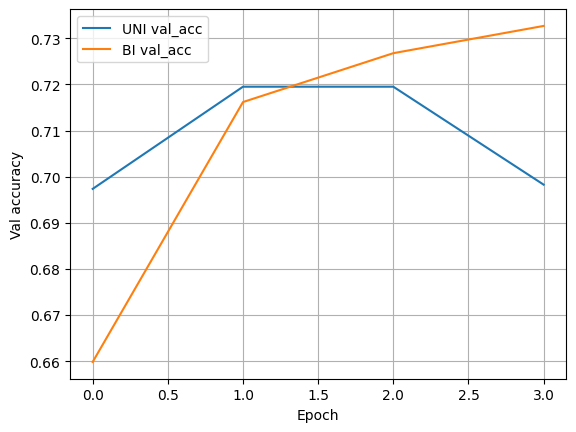

Δ test acc: 0.02621673485812015
Δ params: 192512


In [ ]:

# Bi-directional 

best_cfg_bi = dict(best_cfg_uni)
best_cfg_bi["bidirectional"] = True

bi_model, bi_hist, bi_pack = fit(best_cfg_bi, epochs=12, batch_size=64, patience=2, verbose=True)
_, _, bi_test_loader, bi_stoi, bi_itos = bi_pack

bi_test_loss, bi_test_acc = evaluate(bi_model, bi_test_loader, criterion)
print("BI Test acc:", bi_test_acc)
print("BI Params:", count_params(bi_model))

plt.figure()
plt.plot(uni_hist["val_acc"], label="UNI val_acc")
plt.plot(bi_hist["val_acc"], label="BI val_acc")
plt.xlabel("Epoch")
plt.ylabel("Val accuracy")
plt.legend(); plt.grid(True); plt.show()

delta_acc = bi_test_acc - test_acc
delta_params = count_params(bi_model) - count_params(uni_model)
print("Δ test acc:", delta_acc)
print("Δ params:", delta_params)


## Constructed examples where 'future context' matters

In [ ]:
# end-of-sentence
@torch.no_grad()
def predict_probs(model, texts, stoi, seq_len):
    model.eval()
    X = np.stack([encode(t, stoi, seq_len) for t in texts])
    x = torch.from_numpy(X).to(device)
    logits, _ = model(x)
    return torch.sigmoid(logits).detach().cpu().numpy()

examples = [
    "I thought the movie was great at first, but it isn't.",
    "This is not a good film despite the talented cast.",
    "The acting seems brilliant, until the ending ruins it.",
    "What a wonderful idea, executed so poorly.",
    "I laughed a lot, mostly at how bad it was.",
    "It looks promising although it never delivers.",
    "The plot is clever, not.",
    "This is the kind of film you recommend to your enemies.",
]

seq_len = best_cfg_uni["seq_len"]

uni_p = predict_probs(uni_model, examples, uni_stoi, seq_len)
bi_p  = predict_probs(bi_model,  examples, bi_stoi,  seq_len)

for t, up, bp in zip(examples, uni_p, bi_p):
    print(f"Text: {t}")
    print(f"  UNI prob(pos): {float(up):.3f}")
    print(f"  BI  prob(pos): {float(bp):.3f}\n")


Text: I thought the movie was great at first, but it isn't.
  UNI prob(pos): 0.116
  BI  prob(pos): 0.124

Text: This is not a good film despite the talented cast.
  UNI prob(pos): 0.362
  BI  prob(pos): 0.484

Text: The acting seems brilliant, until the ending ruins it.
  UNI prob(pos): 0.501
  BI  prob(pos): 0.247

Text: What a wonderful idea, executed so poorly.
  UNI prob(pos): 0.757
  BI  prob(pos): 0.121

Text: I laughed a lot, mostly at how bad it was.
  UNI prob(pos): 0.035
  BI  prob(pos): 0.020

Text: It looks promising although it never delivers.
  UNI prob(pos): 0.266
  BI  prob(pos): 0.205

Text: The plot is clever, not.
  UNI prob(pos): 0.185
  BI  prob(pos): 0.511

Text: This is the kind of film you recommend to your enemies.
  UNI prob(pos): 0.610
  BI  prob(pos): 0.887



## Embedding stability vs GloVe (dimension matched via PCA)

In [ ]:

# Embedding stability vs GloVe, dimension match, cosine and nearest neighbors

!pip -q install gensim

import gensim.downloader as api
from numpy.linalg import norm
from sklearn.decomposition import PCA

glove = api.load("glove-twitter-25")  # 25-dim

model_for_emb = bi_model
stoi_for_emb  = bi_stoi
itos_for_emb  = bi_itos

E = model_for_emb.embedding.weight.detach().cpu().numpy()  # (V, embed_dim)

def cosine(a, b):
    return float(np.dot(a, b) / (norm(a)*norm(b) + 1e-12))

def get_vec(word):
    idx = stoi_for_emb.get(word, None)
    if idx is None:
        return None
    return E[idx]

target_words = ["plot", "acting", "cheap", "affordable", "excellent", "waste"]
words = [w for w in target_words if (w in stoi_for_emb) and (w in glove)]
print("Using words:", words)

shared = [w for w in itos_for_emb if (w in glove) and (w in stoi_for_emb)]
shared = shared[:3000]

X_model = np.stack([get_vec(w) for w in shared])
pca = PCA(n_components=25, random_state=SEED).fit(X_model)
E25 = pca.transform(E)

def vec25(word):
    return E25[stoi_for_emb[word]]

pairs = [
    ("cheap", "affordable"),
    ("plot", "acting"),
    ("plot", "cheap"),
    ("acting", "waste"),
    ("excellent", "waste"),
    ("plot", "excellent"),
]

for a,b in pairs:
    if a in words and b in words:
        sim_model = cosine(vec25(a), vec25(b))
        sim_glove = cosine(glove[a], glove[b])
        print(f"\n{a} vs {b}")
        print("  Model cosine:", round(sim_model, 3))
        print("  GloVe cosine:", round(sim_glove, 3))

def top_neighbors(word, topk=10):
    idx = stoi_for_emb[word]
    v = E25[idx]
    sims = []
    for i, w in enumerate(itos_for_emb):
        if i == idx or w in ("<pad>","<unk>"):
            continue
        sims.append((w, cosine(v, E25[i])))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:topk]

for w in words:
    print(f"\nNearest neighbors in learned embedding for '{w}':")
    for n, s in top_neighbors(w, topk=10):
        print(" ", n, round(s, 3))


Using words: ['plot', 'acting', 'cheap', 'excellent', 'waste']

plot vs acting
  Model cosine: 0.05
  GloVe cosine: 0.647

plot vs cheap
  Model cosine: -0.075
  GloVe cosine: 0.476

acting vs waste
  Model cosine: -0.069
  GloVe cosine: 0.755

excellent vs waste
  Model cosine: -0.139
  GloVe cosine: 0.634

plot vs excellent
  Model cosine: 0.099
  GloVe cosine: 0.596

Nearest neighbors in learned embedding for 'plot':
  derivative 0.707
  næss' 0.677
  fancies 0.649
  opposing 0.647
  slender 0.635
  patois 0.632
  dès 0.627
  bladerunner 0.626
  almost 0.625
  characterizing 0.624

Nearest neighbors in learned embedding for 'acting':
  corbett 0.641
  tanovic's 0.637
  worlds 0.632
  better 0.624
  d'etre 0.624
  oops 0.623
  omnipotent 0.621
  gorefests 0.616
  woefully 0.614
  phone 0.6

Nearest neighbors in learned embedding for 'cheap':
  fortune 0.707
  showed 0.688
  dealer 0.669
  attacking 0.648
  passionately 0.624
  moon 0.621
  envelope 0.604
  documentarian 0.602
  litte

In [ ]:
# Save models and vocabs

torch.save({
    "model_state_dict": uni_model.state_dict(),
    "config": best_cfg_uni,
    "stoi": uni_stoi,
    "itos": uni_itos
}, "sentiment_rnn_uni.pth")

torch.save({
    "model_state_dict": bi_model.state_dict(),
    "config": best_cfg_bi,
    "stoi": bi_stoi,
    "itos": bi_itos
}, "sentiment_rnn_bi.pth")


In [ ]:
# TensorFlow/Keras version
import tensorflow as tf
from datasets import load_dataset

# Load Rotten Tomatoes dataset
rt = load_dataset("rotten_tomatoes")
train_hf = rt["train"]
val_hf   = rt["validation"]
test_hf  = rt["test"]

VOCAB_SIZE = 20000
MAX_LEN    = 100
EMBED_DIM  = 128
HIDDEN     = 128
DROPOUT    = 0.35
LR         = 2e-3
BATCH_SIZE = 64
EPOCHS     = 5

# Text vectorizer
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN
)

# Adapt on train texts
vectorizer.adapt(train_hf["text"])

# from HF to tf.data.Dataset
ds_train_raw = train_hf.to_tf_dataset(
    columns=["text"],
    label_cols=["label"],
    batch_size=BATCH_SIZE,
    shuffle=True
)
ds_val_raw = val_hf.to_tf_dataset(
    columns=["text"],
    label_cols=["label"],
    batch_size=BATCH_SIZE,
    shuffle=False
)
ds_test_raw = test_hf.to_tf_dataset(
    columns=["text"],
    label_cols=["label"],
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Robust: handle both (x is dict) and (x is tensor)
def vectorize_batch(x, y):
    if isinstance(x, dict):
        x = x["text"]
    x = vectorizer(x)                
    y = tf.cast(y, tf.float32)
    return x, y

ds_train = ds_train_raw.map(vectorize_batch).prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val_raw.map(vectorize_batch).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test_raw.map(vectorize_batch).prefetch(tf.data.AUTOTUNE)

def build_gru_model(bidirectional: bool):
    inputs = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32)
    x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embed")(inputs)
    x = tf.keras.layers.Dropout(DROPOUT)(x)

    gru = tf.keras.layers.GRU(HIDDEN, dropout=DROPOUT, return_sequences=False, name="gru")
    x = tf.keras.layers.Bidirectional(gru, name="bigru")(x) if bidirectional else gru(x)

    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(DROPOUT)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

USE_BIDIRECTIONAL = True
model = build_gru_model(USE_BIDIRECTIONAL)
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)]

history = model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS, callbacks=callbacks)

test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print("Test acc:", float(test_acc))

model.save("best_model.keras")
print("Saved to best_model.keras")



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embed (Embedding)               │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru (Bidirectional)           │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,774,657 (10.58 MB)

 Trainable params: 2,774,657 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.6270 - loss: 0.6357 - val_accuracy: 0.7345 - val_loss: 0.5297
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.8408 - loss: 0.3694 - val_accuracy: 0.7608 - val_loss: 0.4922
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.9258 - loss: 0.1927 - val_accuracy: 0.7514 - val_loss: 0.6689
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9639 - loss: 0.1033 - val_accuracy: 0.7598 - val_loss: 0.7820
Test acc: 0.7804877758026123
Saved to best_model.keras
